In [28]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

from qdisk.classes import FitsImage
from qdisk.plot import Map
from mcmc_tools import EmceeHammer
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
from galario.double import get_image_size

source = "L1489IRS"
center_coord = source_dict[source]["radec"]

def set_grid(u, v, rmax, verbose=True):
    # gridding parameter
    # print(np.min(np.sqrt(u**2+v**2)))
    nxy, dxy = get_image_size(u, v, verbose=verbose, f_min=3)  # in rad
    # print(nxy, dxy/arcsec)

    # condition for GALARIO interpolation: dxy/2 - Rmin > 5 * dR
    # not to make dR too small, adopt dxy/2/1000 as Rmin
    rmin = dxy / 2.0 * 1e-3  # in rad
    # print(rmin/arcsec)
    # dR = (dxy/2 - Rmin) / 5.0001
    dr = (dxy / 2.0 - rmin) / 5.0001  # in rad
    # dr = 0.01*arcsec
    # print(dr/arcsec)

    r_pad = 2 * dxy  # padding parameter
    rmax = dxy * nxy / np.sqrt(2) + r_pad if rmax is None else rmax # in rad
    # rmax = 10*arcsec
    # print(rmax/arcsec)

    # radial grid on image plane
    r = np.arange(rmin, rmax, dr)  # in rad

    return nxy, dxy, r, rmin, dr

def setup_params(param_dict):

    param_name = [
        key for key in param_dict.keys() if not param_dict[key]["fixed"]
    ]
    fixed_param_name = [
        key for key in param_dict.keys() if param_dict[key]["fixed"]
    ]
    bound = [
        param_dict[key]["bound"]
        for key in param_dict.keys()
        if not param_dict[key]["fixed"]
    ]
    initial_state = [
        param_dict[key]["p0"]
        for key in param_dict.keys()
        if not param_dict[key]["fixed"]
    ]

    return param_name, fixed_param_name, bound, initial_state

param_dict_init = {
    # "I_g": {"p0": 8.5, "bound": (-2.0, 20.0), "fixed": False},
    # "sigma_g": {"p0": 2.0, "bound": (0.1, 10), "fixed": False},
    "F_c": {"p0": 10.538, "bound": (5, 15), "fixed": False},
    "sigma_c": {"p0": 0.007, "bound": (1e-5, 0.2), "fixed": False},
    "r0_r": {"p0": 0.2, "bound": (0.2, 0.7), "fixed": False},
    "F_r": {"p0": 8.327, "bound": (3, 13), "fixed": False},
    "sigma_r": {"p0": 0.204, "bound": (1e-2, 1.5), "fixed": False},
    "F_b": {"p0": 9.112, "bound": (4, 14), "fixed": False},
    "sigma_b": {"p0": 1.548, "bound": (0.3, 5), "fixed": False},
    "PA": {"p0": 67.237, "bound": (0, 180), "fixed": False},
    "incl": {"p0": 70.556, "bound": (0, 90), "fixed": False},
    "dRA": {"p0": 0.004, "bound": (-2, 2), "fixed": False},
    "dDec": {"p0": -0.001, "bound": (-2, 2), "fixed": False},
}

def Gaussian1d(r, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-r**2 / (2 * sigma**2))

def GaussianRing1d(r, r0, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(r - r0)**2 / (2 * sigma**2))

def model_func_1d(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b):
    return (
        Gaussian1d(r, F_c, sigma_c)
        + GaussianRing1d(r, r0_r, F_r, sigma_r)
        + Gaussian1d(r, F_b, sigma_b)
    )

# param_dict_init = {
#     # "I_g": {"p0": 8.5, "bound": (-2.0, 20.0), "fixed": False},
#     # "sigma_g": {"p0": 2.0, "bound": (0.1, 10), "fixed": False},
#     "F_c": {"p0": 10.538, "bound": (5, 15), "fixed": False},
#     "sigma_c": {"p0": 0.007, "bound": (1e-5, 0.2), "fixed": False},
#     "r0_r": {"p0": 0.2, "bound": (0.2, 0.7), "fixed": False},
#     "F_r": {"p0": 8.327, "bound": (3, 13), "fixed": False},
#     "sigma_r": {"p0": 0.204, "bound": (1e-2, 1.5), "fixed": False},
#     "F_b": {"p0": 9.112, "bound": (4, 14), "fixed": False},
#     "sigma_b": {"p0": 1.548, "bound": (0.3, 5), "fixed": False},
#     "r_1": {"p0": 1.58, "bound": (0.5, 14), "fixed": False},
#     "F_1": {"p0": 2, "bound": (0, 14), "fixed": False},
#     "sigma_1": {"p0": 0.2, "bound": (0.05, 5), "fixed": False},
#     "r_2": {"p0": 2.25, "bound": (4, 14), "fixed": False},
#     "F_2": {"p0": 2, "bound": (0, 14), "fixed": False},
#     "sigma_2": {"p0": 0.18, "bound": (0.05, 5), "fixed": False},
#     "PA": {"p0": 67.237, "bound": (0, 180), "fixed": False},
#     "incl": {"p0": 70.556, "bound": (0, 90), "fixed": False},
#     "dRA": {"p0": 0.004, "bound": (-2, 2), "fixed": False},
#     "dDec": {"p0": -0.001, "bound": (-2, 2), "fixed": False},
# }

# ring2 = GaussianRing1d(r, 1.58, -5.2, 0.2)
# ring3 = GaussianRing1d(r, 2.25, -5.5, 0.18)

param_name, fixed_param_name, bound, initial_state = setup_params(param_dict_init)

hammer = EmceeHammer()
hammer.load_backend("./L1489IRS_continuum_shift.split.bin_30s.GaussianSingleRing.h5")
MAP_params = hammer.get_MAP_params()
param_dict = np.load("./L1489IRS_SBLB_continuum_PointSource_GaussianRing_Gaussian_MAP_param.npy", allow_pickle=True)
# param_dict = {name: param_dict_init[p]["p0"] for name, p in zip(param_name, param_dict_init)}
# param_dict = {name: p for name, p in zip(param_name, MAP_params)}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
param_dict

{'F_c': 10.605192913068061,
 'sigma_c': 0.0073545781445531954,
 'r0_r': 0.4063368182219162,
 'F_r': 8.454477555247845,
 'sigma_r': 0.2153656832364829,
 'F_b': 9.170744957430598,
 'sigma_b': 1.59279900897857,
 'PA': 68.82817451433837,
 'incl': 72.87134069141945,
 'dRA': 0.008847723529231867,
 'dDec': 0.0008004754782387096}

In [30]:
import astropy.constants as ac
import astropy.units as units
from visibility import Visibility
from galario.double import sampleProfile

c = ac.c.to(units.m / units.s).value
pi = np.pi
deg = pi / 180.0  # in rad
arcsec = pi / 180.0 / 3600.0  # in rad

vis = Visibility("./visibility/L1489IRS_continuum_shift.split.bin_30s.npz")

u = vis.u
v = vis.v

nxy, dxy, r, rmin, dr = set_grid(u, v, rmax=None)

def sample_vis(param_dict):

    # retrieve geometrical params
    PA = param_dict.pop("PA")
    incl = param_dict.pop("incl")
    dRA = param_dict.pop("dRA")
    dDec = param_dict.pop("dDec")

    # get model array
    model = model_func_1d(r / arcsec, **param_dict)

    # sampling by GALARIO
    V = sampleProfile(
        intensity=model,
        Rmin=rmin,
        dR=dr,
        nxy=nxy,
        dxy=dxy,
        u=u,
        v=v,
        dRA=dRA * arcsec,
        dDec=dDec * arcsec,
        PA=PA * deg,
        inc=incl * deg,
        check=False,
    )

    return V

V = sample_vis(param_dict)

dxy:4.955479e-03arcsec	nxy_MRS:8192
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:3 and MRS:1.353176e+01arcsec


In [31]:
np.savez("./L1489IRS_continuum_shift_oldDDT.split.bin_30s.MAP_vis.npz", u=u, v=v, V=V, weight=vis.weight)

In [115]:
from visibility import Visibility
vis = Visibility("./visibility/L1489IRS_continuum_shift.split.bin_30s.npz")
vis.deproject(PA=param_dict["PA"], incl=param_dict["incl"])
vis.shift_phase(dRA=-param_dict["dRA"], dDec=-param_dict["dDec"])
uv, V, Verr = vis.bin_1D()
filename = "./visibility/L1489IRS_continuum_shift.split.bin_30s.uvprofile.npz"
np.savez(filename, uvdist=uv, V=V, Verr=Verr)

In [32]:
# param_dict = np.load("./L1489IRS_SBLB_continuum_PointSource_GaussianRing_Gaussian_MAP_param.npy", allow_pickle=True)
param_dict = {name: p for name, p in zip(param_name, MAP_params)}
# filename = "./L1489IRS_continuum_shift_oldDDT.MAP_vis.npz"
modelvis = Visibility("./L1489IRS_continuum_shift_oldDDT.split.bin_30s.MAP_vis.npz")
modelvis.deproject(PA=param_dict["PA"], incl=param_dict["incl"])
modelvis.shift_phase(dRA=-param_dict["dRA"], dDec=-param_dict["dDec"])
uvdist, V, Verr = modelvis.bin_1D()
filename = "./L1489IRS_continuum_shift_oldDDT.split.bin_30s.MAP_vis.uvprofile.npz"
np.savez(filename, uvdist=uvdist, V=V, Verr=Verr)

[(-2.2, 2.2),
 Text(0, 0.5, 'Imag [mJy]'),
 Text(0.5, 0, 'Baseline [k$\\lambda$]')]

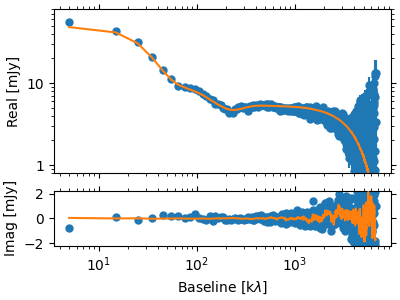

In [33]:
from tkinter import Scale
from matplotlib.ticker import ScalarFormatter, LogFormatter, StrMethodFormatter, FormatStrFormatter

filename = "./visibility/L1489IRS_continuum_shift.split.bin_30s.uvprofile.npz"
obsdata = np.load(filename)
uvdist = obsdata["uvdist"]
V = obsdata["V"]
Verr = obsdata["Verr"]

filename = "./L1489IRS_continuum_shift_oldDDT.split.bin_30s.MAP_vis.uvprofile.npz"
modeldata = np.load(filename)
modeluvdist = modeldata["uvdist"]
modelV = modeldata["V"]
modelVerr = modeldata["Verr"]

# oldvis = Visibility("./visibility/L1489IRS_continuum_shift_oldDDT.npz")
# oldvis.deproject(PA=param_dict["PA"], incl=param_dict["incl"])
# oldvis.shift_phase(dRA=-param_dict["dRA"], dDec=-param_dict["dDec"])
# olduvdist, oldV, oldVerr = oldvis.bin_1D()
# filename = "./L1489IRS_continuum_shift_oldDDT.uvprofile.npz"
# np.savez(filename, uvdist=olduvdist, V=oldV, Verr=oldVerr)


fig, axes = plt.subplots(
    2,
    1,
    figsize=(4, 3),
    sharex=True,
    gridspec_kw={"height_ratios": (3, 1)},
    constrained_layout=True,
)

ax = axes[0]
ax.errorbar(uvdist*1e-3, V.real*1e3, yerr=Verr.real*1e3, fmt="o", markersize=5)
ax.plot(modeluvdist*1e-3, modelV.real*1e3, zorder=100)
# ax.errorbar(olduvdist, oldV.real, yerr=oldVerr.real, fmt="o", markersize=5, zorder=2000)
ax.set(xscale="log", ylim=(0.8, 80), yscale="log", ylabel="Real [mJy]")
formatter = FormatStrFormatter("%.0f")
ax.yaxis.set_major_formatter(formatter)

ax = axes[1]
ax.errorbar(uvdist*1e-3, V.imag*1e3, yerr=Verr.imag*1e3, fmt="o", markersize=5)
ax.plot(modeluvdist*1e-3, modelV.imag*1e3, zorder=100)
# ax.errorbar(olduvdist, oldV.imag, yerr=oldVerr.imag, fmt="o", markersize=5, zorder=2000)
ax.set(ylim=(-2.2, 2.2), ylabel="Imag [mJy]", xlabel="Baseline [k$\lambda$]")

In [27]:
fig.savefig("./figure/visibility_plot.png", bbox_inches="tight", pad_inches=0.01, dpi=800)

In [41]:
param_dict

{'F_c': 10.557048331533563,
 'sigma_c': 0.007494813542380357,
 'r0_r': 0.3217412969891356,
 'F_r': 8.591130452149391,
 'sigma_r': 0.2673455619106986,
 'F_b': 9.172524555034434,
 'sigma_b': 1.623905823826042,
 'PA': 66.94035666648165,
 'incl': 71.58432498765475,
 'dRA': 0.009104765754575464,
 'dDec': 0.001009470925116401}

In [42]:
def Ring1d(r, r0_r, F_r, sigma_r):
    peak = F_r / (2 * sigma_r)
    return np.where((r >= r0_r - sigma_r) & (r <= r0_r + sigma_r), peak, 0)

In [43]:
from analysis_utils import Gaussian1d, GaussianRing1d, FourthPowerGaussian1d, FourthPowerGaussianRing1d
from astropy.convolution import convolve_fft, Gaussian2DKernel

def model_func_1d(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b, r_1, F_1, sigma_1, r_2, F_2, sigma_2):
    return (
        Gaussian1d(r, F_c, sigma_c)
        + GaussianRing1d(r, r0_r, F_r, sigma_r)
        + Gaussian1d(r, F_b, sigma_b)
        + GaussianRing1d(r, r_1, F_1, sigma_1)
        + GaussianRing1d(r, r_2, F_2, sigma_2)
    )

def model_func_1d(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b):
    return (
        Gaussian1d(r, F_c, sigma_c)
        + GaussianRing1d(r, r0_r, F_r, sigma_r)
        + Gaussian1d(r, F_b, sigma_b)
    )

# def model_func_1d(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b):
#     return (
#         Gaussian1d(r, F_c, sigma_c)
#         + Ring1d(r, r0_r, F_r, sigma_r)
#         + Gaussian1d(r, F_b, sigma_b)
#     )

In [51]:
basefits = "/works/yamato/eDisk/L1489IRS/eDisk_image_products/L1489IRS_SBLB_continuum_robust_1.0.pbcor.tt0.fits"

PA = param_dict.pop("PA")
incl = param_dict.pop("incl")

from analysis_utils import FWHM_to_sigma

im = FitsImage(basefits, xlim=(-5, 5), ylim=(-5, 5), downsample=5)
im.shift_phasecenter(dx=param_dict.pop("dRA"), dy=param_dict.pop("dDec"))
r, t = im.get_disk_coord(PA=PA, incl=incl)


KeyError: 'dRA'

In [55]:
import casatasks

fitsname = "/works/yamato/eDisk/L1489IRS/eDisk_image_products/L1489IRS_SBLB_continuum_robust_1.0.pbcor.tt0.fits"

outfile = "./L1489IRS_SBLB_continuum_robust_1.0_oldDDT.pbcor.tt0.smoothed"
casatasks.imsmooth(
    imagename=fitsname,
    outfile=outfile,
    targetres=True,
    beam={"major": "0.34arcsec", "minor": "0.23arcsec", "pa": "28deg"},
)


In [56]:
casatasks.exportfits(imagename=outfile, fitsimage=outfile+".fits", dropdeg=True)

/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


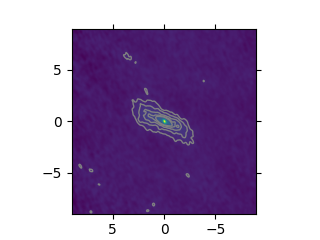

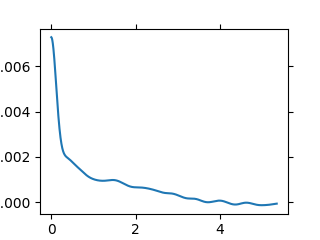

In [59]:
image = Map(outfile+".fits")
image.plot_colormap()
image.overlay_contour(levels=np.array([3, 6, 9, 12, 15])*0.079e-3)


(0.0001, 0.006)

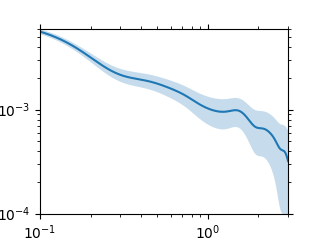

In [74]:
image = FitsImage(outfile+".fits", xlim=(-10, 10), ylim=(-10, 10))
image.shift_phasecenter_toward(center_coord)
image.estimate_rms(rmin=8, rmax=10)
r, I, dI = image.cut(PA=69, )

plt.figure()
plt.plot(r, I)
plt.fill_between(r, I-3*image.rms, I+3*image.rms, alpha=0.25)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.1, 3)
plt.axhline(y=0.0, color="grey", ls="dashed")
plt.ylim(1e-4, 6e-3)
# plt.ylim(0, None)

In [69]:
image.rms

nan

In [45]:
def diskmodel(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b):

    model = model_func_1d(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b)
    beam_kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(im.bmaj)/im.dpix, y_stddev=FWHM_to_sigma(im.bmin)/im.dpix, theta=np.radians(im.bpa+90))
    model = convolve_fft(model, beam_kernel) * im.Omega_beam_str

    return model

ValueError: Image and kernel must have same number of dimensions

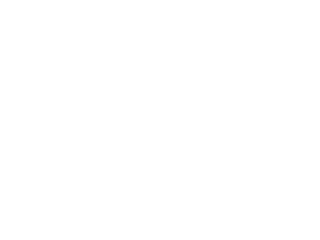

In [39]:
plt.figure()
model = diskmodel(r, **param_dict)
im.data = model.copy()
r, I, dI = im.radial_profile(PA=PA, incl=incl, wedge_angle=45, rmax=8)
plt.plot(r, I)
plt.yscale("log")


In [30]:
1.5e8*im.Omega_beam_str

2.2816779349451487e-05

In [6]:
import lmfit

model = lmfit.Model(diskmodel)

# param_dict = {"Mstar": {"val": 2.0, "range": (0.001, 10), "free": True}}
params = model.make_params()

for param in model.param_names:
    params[param].set(
        value=param_dict[param],
        min=param_dict_init[param]["bound"][0],
        max=param_dict_init[param]["bound"][1],
        vary=~param_dict_init[param]["fixed"],
    )

In [7]:
fit = model.fit(r=r, data=im.data, weights=1/1.6e-3, params=params, method='leastsq')
print(fit.fit_report())

KeyboardInterrupt: 

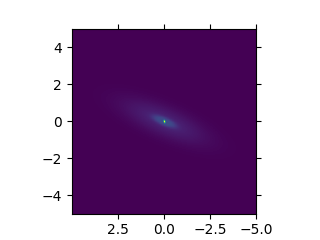

In [46]:
from astropy.visualization import AsinhStretch

model = diskmodel(r, **param_dict)
modelmap = Map(model, x=im.x, y=im.y)
modelmap.plot_colormap(vmin=0.0, stretch=AsinhStretch(a=0.02))

In [47]:
r, obs, dobs = im.radial_profile(PA=PA, incl=incl, wedge_angle=45, rmax=8)

im.data = model.copy()

r, I, dI = im.radial_profile(PA=PA, incl=incl, wedge_angle=45, rmax=8)

# im.data = central.copy()

# r, Ic, dIc = im.radial_profile(PA=PA, incl=incl, wedge_angle=45, rmax=8)

# im.data = gauss.copy()

# r, Ig, dIg = im.radial_profile(PA=PA, incl=incl, wedge_angle=45, rmax=8)




Calculating radial profile...
Done.
Calculating radial profile...
Done.


Calculating radial profile...
Done.


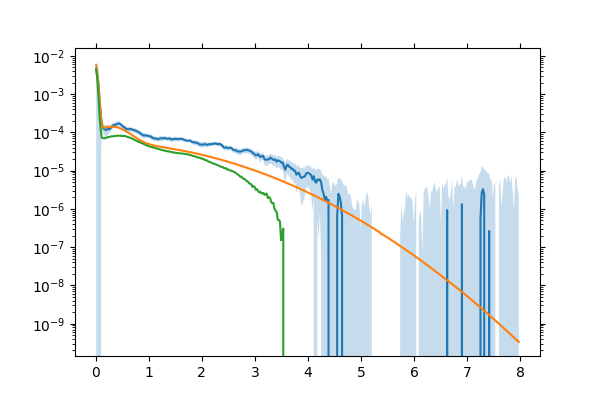

In [50]:
from analysis_utils import PowerLaw

gap = -GaussianRing1d(r, 0.04, -3.58, 0.15)
ring2 = GaussianRing1d(r, 1.58, -5.2, 0.2)
ring3 = GaussianRing1d(r, 2.25, -5.5, 0.18)
gamma = 1.0
r0 = 5.8
theta = 0.2
pout = 20
nuker = PowerLaw(r, -4.02, -gamma) * (1 + (r/r0) ** (1/theta))**((gamma-pout)*theta)
gamma = 1.0
beta = 20
F = 10**(-4.02)
plaw = F * (r/r0) ** (-gamma) * np.exp(-(r/r0)**(-beta))

bastfit = "./L1489IRS_archival_SBLB_continuum_robust1.0_model_PointSource_GaussianRing_Gaussian.image.tt0.fits"

# PA = param_dict.pop("PA")
# incl = param_dict.pop("incl")

from analysis_utils import FWHM_to_sigma

param_dict = {name: p for name, p in zip(param_name, MAP_params)}
im = FitsImage(bastfit, xlim=(-5, 5), ylim=(-5, 5), downsample=5)
im.shift_phasecenter(dx=param_dict.pop("dRA"), dy=param_dict.pop("dDec"))
rr, II, dII = im.radial_profile(PA=PA, incl=incl, wedge_angle=45, rmax=8)


plt.figure(figsize=(6,4))
# plt.plot(r, I)
# plt.plot(r, obs-ring)
plt.plot(r, obs)
# plt.plot(r, Ic)
# plt.plot(r, Ig)
plt.plot(r, I)
plt.plot(rr, II)
# plt.plot(r, I+ring2+ring3)
# plt.plot(r, nuker+gap+ring2+ring3)
# plt.plot(r, Ic+Ig)
plt.fill_between(r, obs-3*dobs, obs+3*dobs, alpha=0.25)
plt.yscale("log")
# plt.xscale("log")
# plt.ylim(2e-5, 20e-3)
# plt.xlim(0, 8)
# plt.ylim(1e-6, 2e-2)

In [44]:
146*0.4

58.400000000000006